In [1]:
# Cell 1: Import Libraries and Set Up Environment
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3153723332.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3153723332.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3153723332.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_2296\3153723332.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecat

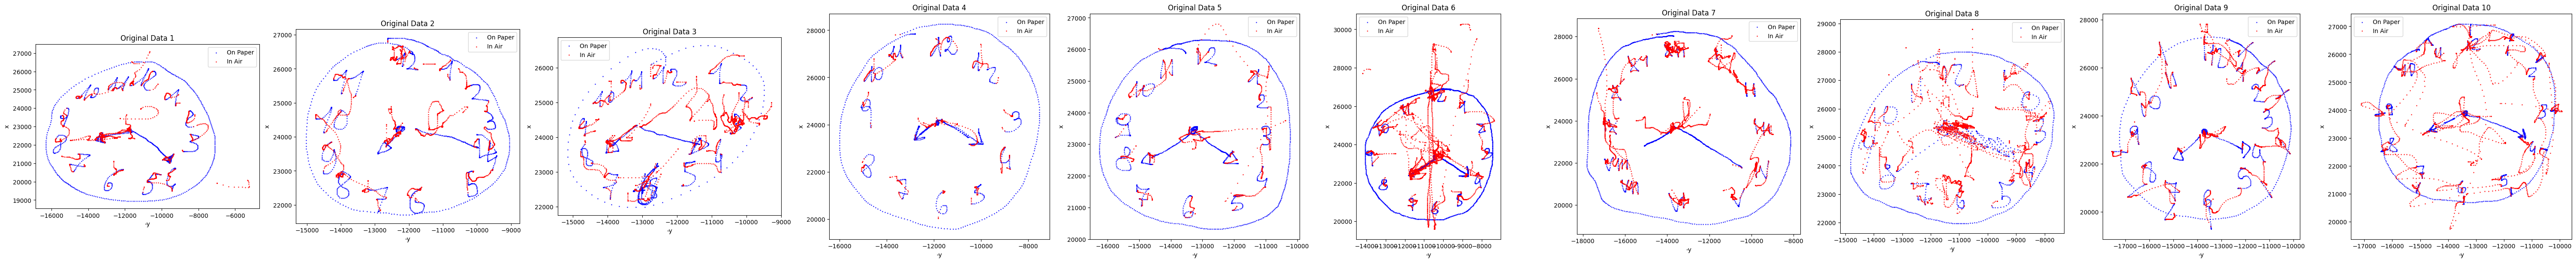

Processed data shape: (45694, 3)
Average number of data points: 4569


In [31]:
# Cell 2: Data Upload, Normalization, and Visualization
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task6'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=10)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [32]:
# Cell 3: Define encoder and decoder

# Sampling layer (needed for reparameterization trick)
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder model
encoder_inputs = Input(shape=(combined_data.shape[1],))
x = Dense(64, activation='relu')(encoder_inputs)
x = Dense(32, activation='relu')(x)
z_mean = Dense(16, name='z_mean')(x)
z_log_var = Dense(16, name='z_log_var')(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

# Decoder model
latent_inputs = Input(shape=(16,))
x = Dense(32, activation='relu')(latent_inputs)
x = Dense(64, activation='relu')(x)
decoder_outputs = Dense(combined_data.shape[1], activation='sigmoid')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

# Display encoder and decoder summaries
encoder.summary()
decoder.summary()

# Continue with VAE definition
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        # Ensure inputs are a single tensor
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()((z_mean, z_log_var))
        reconstructed = self.decoder(z)
        return reconstructed

    def compute_loss(self, inputs):
        # Ensure inputs are a single tensor
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()((z_mean, z_log_var))
        reconstructed = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed))

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        
        # Combined loss
        vae_loss = tf.reduce_mean(reconstruction_loss + self.beta * kl_loss)

        return vae_loss

    def train_step(self, data):
        # Ensure that data is a single tensor
        data = data[0]  # Extract the tensor if it's provided as a tuple
        with tf.GradientTape() as tape:
            loss = self.compute_loss(data)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}

# Build and compile VAE model
vae = VAE(encoder, decoder, beta=1.0)
vae.compile(optimizer=Adam())
vae.summary()

# Train VAE
history = vae.fit(combined_data, combined_data, epochs=5, batch_size=32, verbose=1)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │        256 │ input_layer_41[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │      2,080 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        528 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        528 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,392 (13.25 KB)

 Trainable params: 3,392 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 16), (None,    │         3,392 │
│                                 │ 16)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 3)              │         2,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,243 (24.39 KB)

 Trainable params: 6,243 (24.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.1211
Epoch 2/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1197
Epoch 3/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1195
Epoch 4/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1194
Epoch 5/5
1428/1428 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1194


In [33]:
# Cell 4: Define the LSTM Discriminator and GAN training loop
latent_dim = 16  # This should match the dimension of z_mean and z_log_var in the encoder

# Modify the discriminator to accept 2D input
discriminator_input = Input(shape=(3,))  # Changed from (None, 3) to (3,)
x = RepeatVector(1)(discriminator_input)  # Add a time dimension
x = LSTM(64)(x)
output_layer = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, output_layer)
discriminator.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# Combined model (for training the generator)
generator_input = Input(shape=(latent_dim,))
generated_sample = vae.decoder(generator_input)
discriminator_output = discriminator(generated_sample)
combined_model = Model(generator_input, discriminator_output)
combined_model.compile(optimizer=Adam(), loss=binary_crossentropy)

# Training Loop for GAN
epochs = 5
# Define batch size
batch_size = 512  # New batch size

# Calculate steps_per_epoch based on the actual data size
steps_per_epoch = max(1, combined_data.shape[0] // batch_size)

for epoch in tqdm(range(epochs), desc="Epochs"):
    epoch_d_losses = []
    epoch_g_losses = []
    
    for step in tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        # Select random data for training
        idx = np.random.randint(0, combined_data.shape[0], batch_size)
        real_data = combined_data[idx]

        # Generate fake data
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_data = vae.decoder.predict(noise, verbose=0)

        # Ensure fake_data has the same shape as real_data
        if fake_data.shape != real_data.shape:
            fake_data = fake_data.reshape(real_data.shape)

        # Labels for real and fake data
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_data, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        epoch_d_losses.append(d_loss)

        # Train generator (via combined model)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined_model.train_on_batch(noise, real_labels)
        epoch_g_losses.append(g_loss)

        # Add print statements for each step
        print(f"Training step {step+1} of {steps_per_epoch} in epoch {epoch+1}")
        print(f"Real data shape: {real_data.shape}, Fake data shape: {fake_data.shape}")

    # Calculate average losses for the epoch
    avg_d_loss = np.mean(epoch_d_losses, axis=0)
    avg_g_loss = np.mean(epoch_g_losses)

    # Print losses for each epoch
    print(f"Epoch {epoch+1}/{epochs} [D loss: {avg_d_loss[0]:.4f}, acc.: {100*avg_d_loss[1]:.2f}%] [G loss: {avg_g_loss:.4f}]")

print("Training completed.")

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training step 1 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 2 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 3 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 4 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 5 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 6 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 7 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 8 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 9 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 10 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 11 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 12 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 13 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 14 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 15 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 16 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 17 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 18 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 19 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 20 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 21 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 22 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 23 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 24 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 25 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 26 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 27 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 28 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 29 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 30 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 31 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 32 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 33 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 34 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 35 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 36 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 37 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 38 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 39 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 40 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 41 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 42 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 43 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 44 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 45 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 46 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 47 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 48 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 49 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 50 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 51 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 52 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 53 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 54 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 55 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 56 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 57 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 58 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 59 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 60 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 61 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 62 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 63 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 64 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 65 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 66 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 67 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 68 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 69 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 70 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 71 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 72 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 73 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 74 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 75 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 76 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 77 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 78 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 79 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 80 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 81 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 82 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 83 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 84 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 85 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 86 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 87 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 88 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)


Epochs:  20%|██        | 1/5 [06:57<27:51, 417.88s/it]

Training step 89 of 89 in epoch 1
Real data shape: (512, 3), Fake data shape: (512, 3)
Epoch 1/5 [D loss: 0.7043, acc.: 48.47%] [G loss: 0.6296]


Training step 1 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 2 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 3 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 4 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 5 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 6 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 7 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 8 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 9 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 10 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 11 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 12 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 13 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 14 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 15 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 16 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 17 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 18 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 19 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 20 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 21 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 22 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 23 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 24 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 25 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 26 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 27 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 28 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 29 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 30 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 31 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 32 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 33 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 34 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 35 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 36 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 37 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 38 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 39 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 40 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 41 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 42 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 43 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 44 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 45 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 46 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 47 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 48 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 49 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 50 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 51 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 52 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 53 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 54 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 55 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 56 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 57 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 58 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 59 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 60 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 61 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 62 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 63 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 64 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 65 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 66 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 67 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 68 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 69 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 70 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 71 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 72 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 73 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 74 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 75 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 76 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 77 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 78 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 79 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 80 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 81 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 82 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 83 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 84 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 85 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 86 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 87 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 88 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)


Epochs:  40%|████      | 2/5 [14:48<22:26, 448.92s/it]

Training step 89 of 89 in epoch 2
Real data shape: (512, 3), Fake data shape: (512, 3)
Epoch 2/5 [D loss: 0.7474, acc.: 49.77%] [G loss: 0.6643]


Training step 1 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 2 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 3 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 4 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 5 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 6 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 7 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 8 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 9 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 10 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 11 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 12 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 13 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 14 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 15 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 16 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 17 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 18 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 19 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 20 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 21 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 22 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 23 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 24 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 25 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 26 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 27 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 28 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 29 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 30 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 31 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 32 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 33 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 34 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 35 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 36 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 37 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 38 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 39 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 40 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 41 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 42 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 43 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 44 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 45 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 46 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 47 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 48 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 49 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 50 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 51 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 52 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 53 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 54 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 55 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 56 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 57 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 58 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 59 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 60 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 61 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 62 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 63 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 64 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 65 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 66 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 67 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 68 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 69 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 70 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 71 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 72 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 73 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 74 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 75 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 76 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 77 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 78 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 79 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 80 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 81 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 82 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 83 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 84 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 85 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 86 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 87 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 88 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)


Epochs:  60%|██████    | 3/5 [21:11<13:57, 418.94s/it]

Training step 89 of 89 in epoch 3
Real data shape: (512, 3), Fake data shape: (512, 3)
Epoch 3/5 [D loss: 0.7621, acc.: 49.86%] [G loss: 0.6744]


Training step 1 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 2 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 3 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 4 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 5 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 6 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 7 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 8 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 9 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 10 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 11 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 12 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 13 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 14 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 15 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 16 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 17 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 18 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 19 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 20 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 21 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 22 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 23 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 24 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 25 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 26 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 27 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 28 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 29 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 30 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 31 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 32 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 33 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 34 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 35 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 36 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 37 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 38 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 39 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 40 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 41 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 42 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 43 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 44 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 45 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 46 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 47 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 48 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 49 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 50 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 51 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 52 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 53 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 54 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 55 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 56 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 57 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 58 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 59 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 60 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 61 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 62 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 63 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 64 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 65 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 66 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 67 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 68 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 69 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 70 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 71 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 72 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 73 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 74 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 75 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 76 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 77 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 78 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 79 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 80 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 81 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 82 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 83 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 84 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 85 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 86 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 87 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 88 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)


Epochs:  80%|████████  | 4/5 [27:57<06:53, 413.67s/it]

Training step 89 of 89 in epoch 4
Real data shape: (512, 3), Fake data shape: (512, 3)
Epoch 4/5 [D loss: 0.7619, acc.: 49.90%] [G loss: 0.6743]


Training step 1 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 2 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 3 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 4 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 5 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 6 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 7 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 8 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 9 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 10 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 11 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 12 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 13 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 14 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 15 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 16 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 17 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 18 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 19 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 20 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 21 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 22 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 23 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 24 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 25 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 26 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 27 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 28 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 29 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 30 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 31 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 32 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 33 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 34 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 35 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 36 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 37 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 38 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 39 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 40 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 41 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 42 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 43 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 44 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 45 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 46 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 47 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 48 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 49 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 50 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 51 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 52 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 53 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 54 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 55 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 56 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 57 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 58 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 59 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 60 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 61 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 62 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 63 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 64 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 65 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 66 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 67 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 68 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 69 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 70 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 71 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 72 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 73 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 74 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 75 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 76 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 77 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 78 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 79 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 80 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 81 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 82 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 83 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 84 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 85 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 86 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 87 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Training step 88 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)


Epochs: 100%|██████████| 5/5 [34:51<00:00, 418.34s/it]

Training step 89 of 89 in epoch 5
Real data shape: (512, 3), Fake data shape: (512, 3)
Epoch 5/5 [D loss: 0.7574, acc.: 49.92%] [G loss: 0.6715]
Training completed.


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Augmented data: [[9.0657794e-01 7.0144844e-01 1.2676385e-02]
 [9.0371650e-01 7.0866561e-01 2.1302497e-02]
 [8.9266574e-01 7.4406874e-01 2.5796663e-02]
 ...
 [9.1642642e-01 7.4658328e-01 1.5265738e-02]
 [9.9893492e-01 9.5737678e-01 1.8403536e-05]
 [9.9529880e-01 8.8854849e-01 2.5300533e-04]]


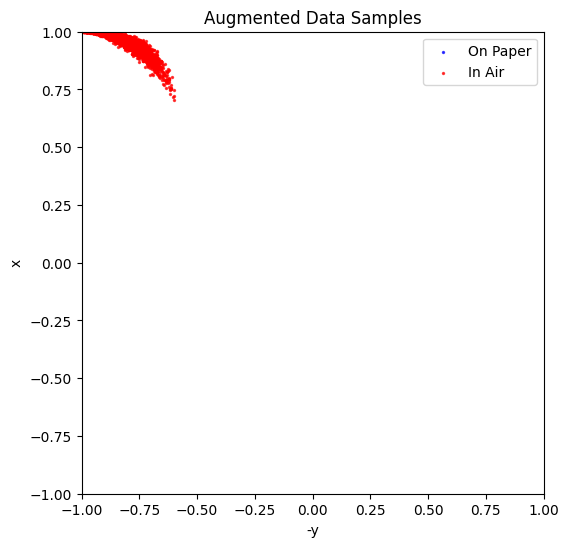

In [36]:
# Cell 5: Augmented Data Generation and Visualization
def generate_augmented_data(num_samples):
    # Generate random noise with the shape (num_samples, 3)
    noise = np.random.normal(size=(num_samples, 3))
    
    # Predict augmented data using the VAE model
    augmented_data = vae.predict(noise)
    return augmented_data

augmented_data = generate_augmented_data(4500)

# Print the augmented data to check its values
print("Augmented data:", augmented_data)

# Plot augmented data
fig, ax = plt.subplots(figsize=(10, 6))

# Split based on pen_status
on_paper_aug = augmented_data[augmented_data[:, 2] >= 0.5]  # Treat values >= 0.5 as 'On Paper'
in_air_aug = augmented_data[augmented_data[:, 2] < 0.5]     # Treat values < 0.5 as 'In Air'

# Plotting
ax.scatter(-on_paper_aug[:, 1], on_paper_aug[:, 0], c='blue', s=2, alpha=0.7, label='On Paper')
ax.scatter(-in_air_aug[:, 1], in_air_aug[:, 0], c='red', s=2, alpha=0.7, label='In Air')

# Set appropriate limits to visualize the data
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

ax.set_title('Augmented Data Samples')
ax.set_xlabel('-y')
ax.set_ylabel('x')
ax.legend()
ax.set_aspect('equal')
plt.show()


ValueError: Shape of passed values is (3, 1), indices imply (3, 3)